# PCA for Source Separation of Ventilation and Cardiovascular Activity in Electrical Impedance Tomography (EIT)

## Introduction
In this exercise we use PCA for processing image sequences of thoracic electrical impedance tomography (EIT) signals. EIT is a non-invasive, radiation-free imaging modality which uses small alternating currents to measure bioimpedance of the thorax [1]. These measurements are then converted into image sequences of thoracic impedance changes representing ventilation (i.e., air exchange in the lungs) and cardiovascular activity (e.g., heart movement or blood volume changes in heart and lungs). 

In order to analyze these data it is important to properly separate ventilation and cardiovascular activity. Besides common techniques such as frequency filtering or ECG-triggered averaging, PCA can be used for separating these two sources of signals.
The present example uses the method proposed by Deibele et al. [2] for which the block diagram is shown below:

<img src="FlowChart_Deibele.png">


## References

[1] I. Frerichs et al., “Chest electrical impedance tomography examination, data analysis, terminology, clinical use and recommendations: consensus statement of the TRanslational EIT developmeNt stuDy group,” Thorax, vol. 72, no. 1, pp. 83–93, Jan. 2017, doi: [10.1136/thoraxjnl-2016-208357](https://dx.doi.org/10.1136/thoraxjnl-2016-208357).

[2] J. M. Deibele, H. Luepschen, and S. Leonhardt, “Dynamic separation of pulmonary and cardiac changes in electrical impedance tomography,” Physiological Measurement, vol. 29, no. 6, pp. S1–S14, Jun. 2008, doi: [10.1088/0967-3334/29/6/S01](https://dx.doi.org/10.1088/0967-3334/29/6/S01).

In [3]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import filtfilt, butter
from scipy.linalg import eigh

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)  # initiate notebook for offline plot

from ecgdetectors import Detectors

In [4]:
# load data
data = loadmat('EIT_Data.mat')
t = data['tEit'].flatten()[data['IdxRange'].flatten().astype(bool)]
fs = 1/np.median(np.diff(t))
imgs_eit = data['Imgs']
b, a = butter(4, np.asarray([0.1, 12]), fs=fs, btype='bandpass')
imgs_eit = filtfilt(b, a, imgs_eit, axis=-1)
imgs_eit *= 1E3  # adapt scaling for plotting

# ECG data to be used for bonus question
ecg = {'time': data['Ecg'][0][0][2], 'value': data['Ecg'][0][0][1], 'fs': data['Ecg'][0][0][3]}
ecg_range = (ecg['time'] > t[0]) & (ecg['time'] < t[-1])
ecg['time'] = ecg['time'][ecg_range]
ecg['value'] = ecg['value'][ecg_range]

# force all timings to start at zero
t -= t[0]
ecg['time'] -= ecg['time'][0]

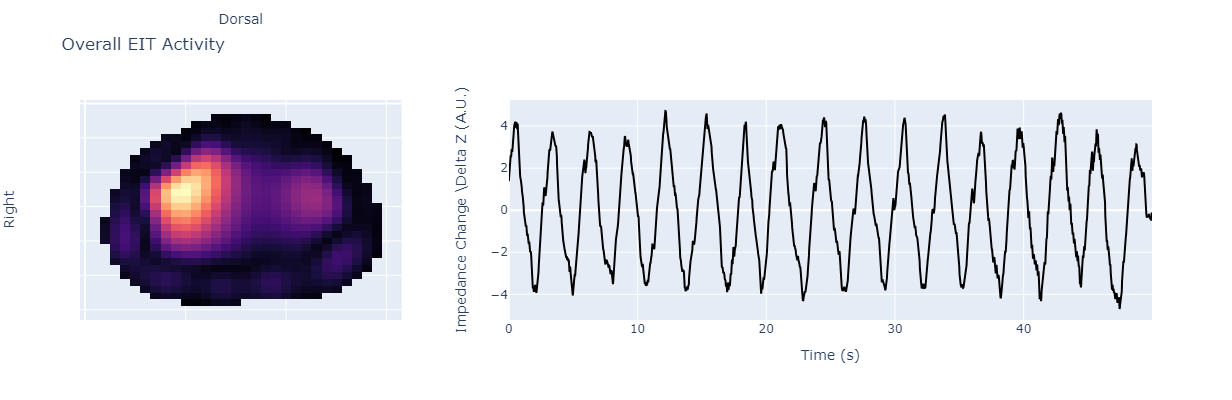

In [5]:
# plot input data
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_eit, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Overall EIT Activity')

fig.add_trace(go.Scatter(x=t, y=np.nansum(imgs_eit, axis=(0, 1)), 
                         name='Overall Sum Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)


In [6]:
def compute_principal_components(X):
    # perform PCA and compute principal components (pc) and eigenvalues of X
    A = np.dot(X.transpose(), X)  # covariance matrix
    [eigenvalues, eigenvectors] = eigh(A)
    pc = np.dot(X, eigenvectors)
    return pc, eigenvalues

def estimate_cardiac_frequency(s, fs):
    sign_cardiac = np.sign(s)
    # find where zero crossings occured
    index = np.where(np.diff(sign_cardiac) == 2)[0]
    # interpolate to a sub-sample resolution
    pos = index + s[index + 1] / (s[index + 1] - s[index])
    # interpolate RR interval values
    rr = np.diff(pos) / fs
    return 1/np.median(rr)

def lms(A, B):
    if B.ndim == 1:
        B = np.asmatrix(B).transpose()
    tmp = np.linalg.solve(np.dot(B.transpose(), B), B.transpose())
    return np.dot(np.dot(B, tmp), A)

# separate ventilation and cardiovascular activity using PCA
# according to the algorithm by Deibele et al., PhysMeas, 2008
# https://dx.doi.org/10.1088/0967-3334/29/6/S01
imgs_tmp = np.reshape(imgs_eit, [-1, imgs_eit.shape[-1]])
are_valid_pixels = np.all(~np.isnan(imgs_tmp), 1)
X = imgs_tmp[are_valid_pixels, :].transpose()

# first approximation (see block diagram)
X = X - np.repeat(np.reshape(np.mean(X, 0), [1, -1]), X.shape[0], 0)
PC1, lambda1 = compute_principal_components(X)
Bv = PC1[:, -1]
Xv_ = lms(X, Bv)
Xc_ = X - Xv_

# second approximation (see block diagram)
Xc_ = Xc_ - np.repeat(np.reshape(np.mean(Xc_, 0), [1, -1]), Xc_.shape[0], 0)
b, a = butter(6, np.asarray([0.92, 4.6]), fs=fs, btype='bandpass')
Xc_bp = filtfilt(b, a, Xc_, axis=0)
PC2, lambda2 = compute_principal_components(Xc_bp)
Bc_ = PC2[:, -2:]
fc = estimate_cardiac_frequency(Bc_[:, 0], fs)

# create cardiac template functions
Bc = np.hstack((Bc_, np.roll(Bc_, int(fs/fc/3), 0),
                np.roll(Bc_, -int(fs/fc/3), 0)))
Xc1 = lms(Xc_, Bc)
Xc2 = lms(Xv_, Bc)
Xc = (Xc1 + Xc2).transpose()
Xv = (Xv_ - Xc2).transpose()

# cardiovascular activity
imgs_card = np.full(imgs_tmp.shape, np.nan)
imgs_card[are_valid_pixels, :] = Xc
imgs_card = imgs_card.reshape(imgs_eit.shape)
# ventilation activity
imgs_vent = np.full(imgs_tmp.shape, np.nan)
imgs_vent[are_valid_pixels, :] = Xv
imgs_vent = imgs_vent.reshape(imgs_eit.shape)

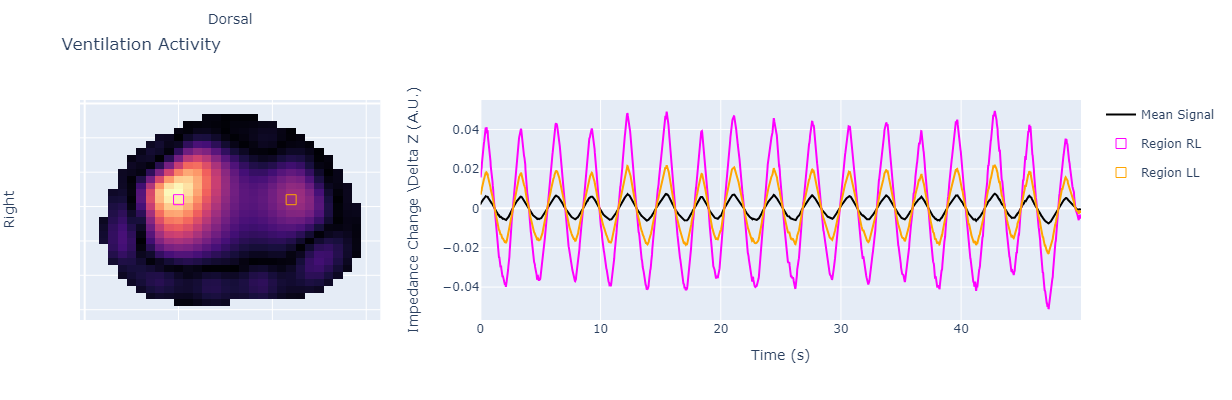

In [7]:
# plot ventilation acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_vent, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Ventilation Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_vent, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add example signals in ??? regions
regions = {'Region RL': ([10, 14], 'magenta'), 'Region LL': ([22, 14], 'orange')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_vent[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2) 
    
fig.show()

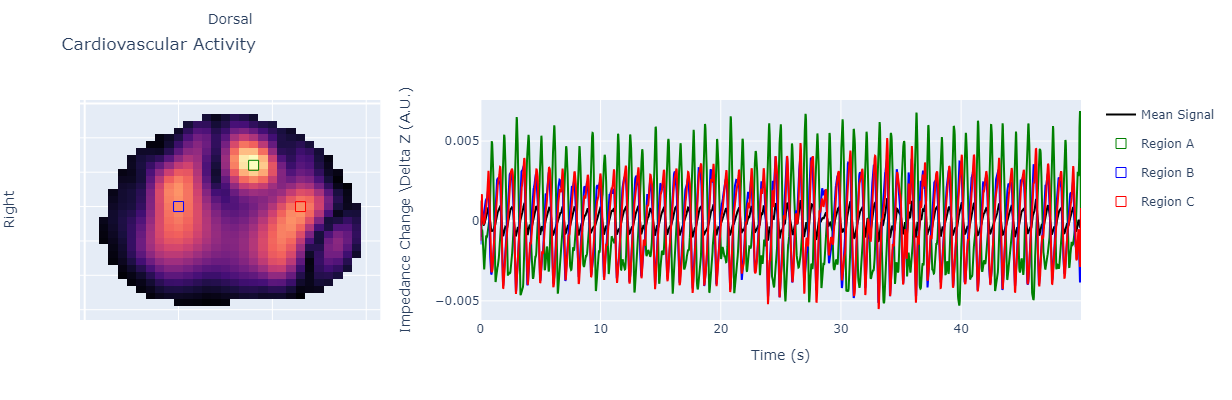

In [8]:
# plot cardiovascular acticity
fig = make_subplots(rows=1, cols=2, column_widths=[1, 2])
fig.update_layout(width=950, height=400)

fig.add_trace(go.Heatmap(z=np.std(imgs_card, axis=-1), zmin=0, 
                         showscale=False, colorscale='magma'), row=1, col=1)
fig.update_yaxes(title='Right', showticklabels=False, autorange="reversed", row=1, col=1)
fig.update_xaxes(title='Dorsal', showticklabels=False, row=1, col=1)
fig.update_layout(title='Cardiovascular Activity')

fig.add_trace(go.Scatter(x=t, y=np.nanmean(imgs_card, axis=(0, 1)), 
                         name='Mean Signal', line_color='black'), row=1, col=2)
fig.update_xaxes(title='Time (s)', row=1, col=2)
fig.update_yaxes(title='Impedance Change \Delta Z (A.U.)', row=1, col=2)

# add three example signals in ??? regions
regions = {'Region A': ([18, 9], 'green'), 'Region B': ([10, 15], 'blue'), 'Region C': ([23, 15], 'red')}
for reg, tmp in regions.items():
    fig.add_scatter(x=[tmp[0][0]], y=[tmp[0][1]], mode='markers', marker_symbol='square-open', 
                    marker_size=10, legendgroup=reg, marker_color=tmp[1], name=reg, row=1, col=1)
    fig.add_trace(go.Scatter(x=t, y=imgs_card[tmp[0][1], tmp[0][0], :], legendgroup=reg, 
                             showlegend=False, name=reg, line_color=tmp[1]), row=1, col=2)    
fig.show()

# Exercise Questions
Please provide your answers directly below each question.

---

## Question 1 
Determine the frequency of the ventilation activity (i.e., the respiratory rate), both expressed in `Hz` and `respirations/min`.

In [9]:
#The ventilation activity signal:
import matplotlib.pyplot as plt
import scipy.signal as ss

#We select the mean signal of the separated ventilation signal by PCA
vent_mean_signal = np.nanmean(imgs_vent, axis=(0, 1))

#We find the peaks positions, here the distance is crucial for finding the maximal value in that samples #range.
vent_peak, _ = ss.find_peaks(vent_mean_signal, height = 0, distance = fs)

#Calculate the frequency of the ventilation
interval = np.diff(vent_peak)/fs
average_interval = np.mean(interval)
freq_ventilation = 1/average_interval
ventilation_pm = freq_ventilation*60
print("frequency in Hz:" , freq_ventilation)
print("Respirations per min: ", ventilation_pm)


frequency in Hz: 0.33150385697100737
Respirations per min:  19.89023141826044


## Question 2
Determine the frequency of the cardiovascular activity, both expressed in `Hz` and `beats/min`.

In [10]:
#We consider again the mean signal, because we assume that this signal shows the overall #cardiovascular activity on the chest and not in isolated regions
cardiac_signal= np.nanmean(imgs_card, axis=(0, 1))
cardiac_peak, _ = ss.find_peaks(cardiac_signal, height = 0, distance = 1)

#Calculate the frequency of the ventilation
interval = np.diff(cardiac_peak)/fs
average_interval = np.mean(interval)
freq_cardiac = 1/average_interval
cardiac_bpm = freq_cardiac * 60
print("frequency in Hz:" , freq_cardiac)
print("Beats per min: ", cardiac_bpm)


frequency in Hz: 1.3074760011554545
Beats per min:  78.44856006932727


## Question 3
Determine the follwing three values:

- i) the maximal amplitude of ventilation activity; 
- ii) the maximal amplitude of cardiovascular activity; and 
- iii) the ratio between i) and ii), i.e., ventilation vs cardiovascular activity. 

In [11]:
# i) We can see that the signals with the highest impedance are the regions indicated. Therefore for the #ventilation activity we consider the amplitudes of the region RL
tmp_v = [10,14]
vent=imgs_vent[tmp_v[1], tmp_v[0], :]
vent_max_amplitude = np.max(vent)
print("The maximum amplitude in the ventilation signal is: ", vent_max_amplitude)

#ii) Max amplitude cardiovascular: region A
tmp_c = [18, 9]
card = imgs_card[tmp_c[1], tmp_c[0], :]
card_max_amp = np.max(card)
print("The maximum amplitude in the cardiac signal is: ", card_max_amp)

#iii) ratio between ventilation/cardiovascular activity:
ratio = vent_max_amplitude/card_max_amp
print("The ratio between the ventilation and cardiovascular activity is: ", ratio)


The maximum amplitude in the ventilation signal is:  0.0494265076586489
The maximum amplitude in the cardiac signal is:  0.006880543253061409
The ratio between the ventilation and cardiovascular activity is:  7.183518196278646


## Question 4
Determine the eigenvalues of the first three principal components resulting from the first PCA (see variable `PC1`).

In [12]:
#we ordered the list of eigenvalues of the first PCA in decreasing order 
lambda1 = sorted(lambda1, reverse = True)
#print(lambda1)

#We extracted the 3 larger eigenvalues from the first PCA 
print(lambda1[0],lambda1[1],lambda1[2])


107.58688656183709 2.1114888816145316 0.8031524393717161


## Question 5
Similar to Question 4, determine the two most dominant frequencies for the first three principal components. <i>Note that this would lead to a total of 6 values, 2 frequencies for each of the 3 PCA components. However, for some components only one dominant frequency might be present.</i><br>
For all 3 PCA components, which one is rather related to ventilation or cardiovascular activity?

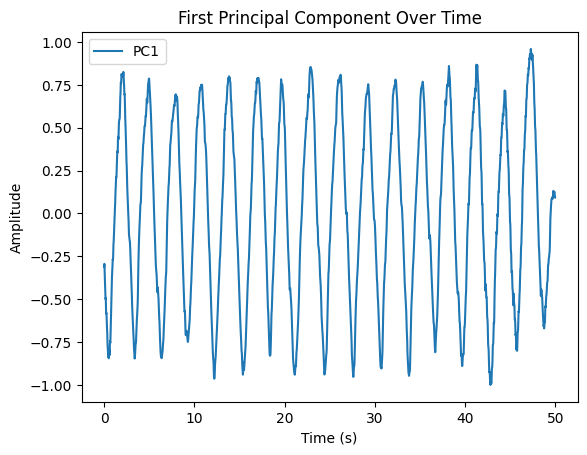

In [13]:
#The three largest principal values, similarly to the eigenvalues are:
pc1 = PC1[:, -1]
pc2 = PC1[:, -2]
pc3 = PC1[:, -3]
#we normalise them just for visualisation
pc1_norm = pc1 / np.max(np.abs(pc1))
pc2_norm = pc2 / np.max(np.abs(pc2))
pc3_norm = pc3 / np.max(np.abs(pc3))

# Plot the first principal component over time
plt.plot(t, pc1_norm, label="PC1")
plt.title("First Principal Component Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()



Visually, it appears that there is basically only one frequency present. To identify it, several methods can be employed such as FFT, PSD, SSA etc, but we have chosen to do a spectral estimation with the welch algorithm:

(0.0, 3.0)

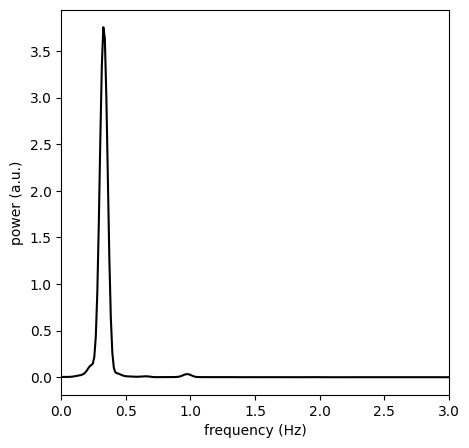

In [14]:
import scipy.signal as sp
import pylab as py
f, dt = sp.welch(pc1_norm, nperseg=1000, nfft=4096, noverlap=750,fs=fs)
#we use a segment length of 1000, a number of points for the fft equal to 4096 and an overlap of 75% for our segments
#Since we care about frequency resolution and less about time resolution we use as large a segment length as possible (we are sure to include many multiples of the lowest frequencies we expect) likewise for overlap, more overlap increases computational cost but allows better capture of transient phenomena.
py.figure(3, figsize=[5,5])
py.clf()
py.plot(f, dt, 'k')
py.xlabel('frequency (Hz)')
py.ylabel('power (a.u.)')
py.xlim(0,3)


With this we are able to distinguish, as expected, a single very prominent peak (and a tiny second peak at 0.9Hz but it is negligible). By zooming in and looking more closely we can see that the peak happens at roughly f=0.33 Hz.

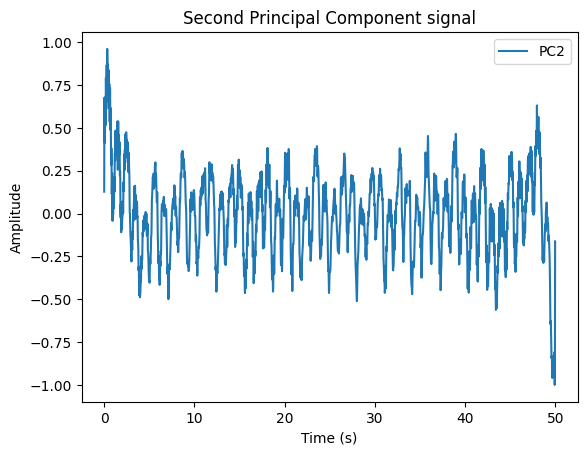

In [15]:
#For the second principal component we do the same:
# Plot the second principal component over time
plt.plot(t, pc2_norm, label="PC2")
plt.title("Second Principal Component signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

#We can see that there is definitely more than one frequency involved now


(0.0, 2.0)

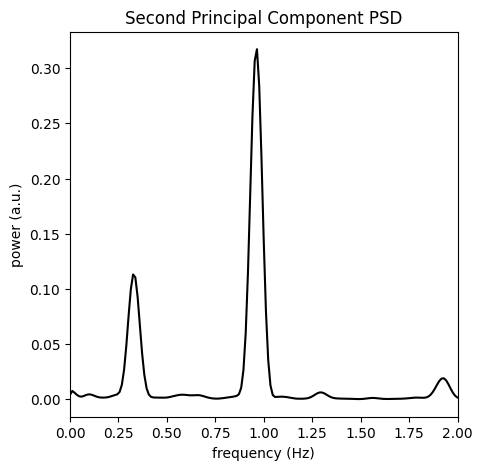

In [16]:
#By once again using the welch spectral power density estimator we can identify the frequencies:

#for second 
f2, dt2 = sp.welch(pc2_norm, nperseg=1000, nfft=4096, noverlap=750,fs=fs)
py.figure(3, figsize=[5,5])
py.clf()
py.plot(f2, dt2, 'k')
plt.title("Second Principal Component PSD")
py.xlabel('frequency (Hz)')
py.ylabel('power (a.u.)')
py.xlim(0,2)


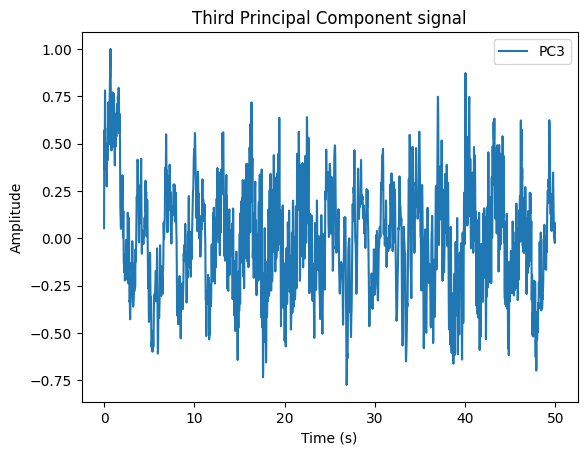

In [17]:
#The two most dominant frequencies correspond to the two largest peaks (at 0.33Hz and 0.9 Hz)

#For the third PCA component signal:

# Plot the third principal component over time
plt.plot(t, pc3_norm, label="PC3")
plt.title("Third Principal Component signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


(0.0, 4.0)

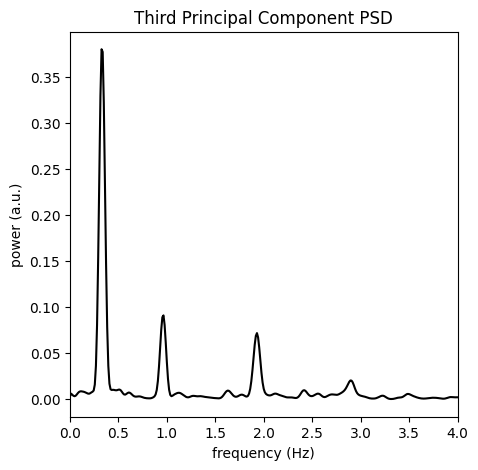

In [18]:
#We can see three distinct peaks in the frequency domain, the last two appearing fairly similar:
#for third
f3, dt3 = sp.welch(pc3_norm, nperseg=1000, nfft=4096, noverlap=750,fs=fs)
py.figure(3, figsize=[5,5])
py.clf()
py.plot(f3, dt3, 'k')
plt.title("Third Principal Component PSD")
py.xlabel('frequency (Hz)')
py.ylabel('power (a.u.)')
py.xlim(0,4)   


The first peak always corresponds to the 0.33Hz frequency and the second always to the 0.9Hz frequency. The last peak is at around 1.9Hz.

For the first PCA component signal the only visible frequency is that at 0.33Hz, which as we have seen is related to the ventilation activity. We can therefore consider that the first principal component represents the respiratory signal.

The second principal component signal shows the same dominant frequency for the ventilation activity but its most dominant frequency is that at 0.9Hz. We can interpret this as meaning that the second principal component is related more to the cardiovascular activity signal with some influence of the respiration.

The last PCA component signal again shows a significant amount of respiration with a combination of both cardiovascular  and another higher frequency signal so it is related to both.


## Question 6
The three example signals (Regions A to C: **green, blue, red**) of cardiovascular activity show the impedance change over time. 
Can you guess the underlying anatomical structure for each of the three example signals (Regions A to C: **green, blue, red**).

Looking at the results given by the provided code, we can see that the green region, region A, has the largest amplitude. Considering that in this kind of image we look at the thorax from below (thus the “dorsal” writing should be opposite with respect to what it is written in the results), we identified the brightest zone as the heart. Then we conclude that the region A corresponds to the heart. Similarly, we look at the lowest intensity and amplitude, i.e. the region B in blue. This corresponds to the right lung. The RL is not affected by the heart pulse, then it translates in a lower amplitude with respect to the left lung. The third region, i.e. region C in red corresponds to the left lung. Its intensity and amplitude is a little bit greater than those of the right lung. We can hypothesise that the heart pulse slightly affects the pulmonary movement.